In [1]:
import warnings
warnings.filterwarnings('ignore')

### Importing the libraries

In [2]:
# import preprocessing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

# Import model algorithms
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

In [3]:
Tel_Aviv = pd.read_csv('/content/Tel_Aviv.csv')
Tel_Aviv.head()

,datetime,pressure,humidity,temperature,weather,wind direction,wind speed
0,2012-10-01 12:00:00,NaN,NaN,NaN,sky is not clear,NaN,NaN
1,2012-10-01 13:00:00,1012.0,63.0,305.470000,sky is clear,0.0,0.0
2,2012-10-01 14:00:00,1012.0,62.0,304.310000,sky is clear,0.0,0.0
3,2012-10-01 15:00:00,1012.0,62.0,304.281841,sky is clear,0.0,0.0
4,2012-10-01 16:00:00,1012.0,62.0,304.238015,sky is clear,0.0,0.0


In [4]:
Tel_Aviv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        45253 non-null  object 
 1   pressure        44323 non-null  float64
 2   humidity        44140 non-null  float64
 3   temperature     44460 non-null  float64
 4   weather         45253 non-null  object 
 5   wind direction  45252 non-null  float64
 6   wind speed      44459 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.4+ MB


In [5]:
Tel_Aviv.isnull().sum()

datetime             0
pressure           930
humidity          1113
temperature        793
weather              0
wind direction       1
wind speed         794
dtype: int64

In [6]:
# Percentage of missing values per column
print('Percentage of missing values in Pressure column :', ((Tel_Aviv['pressure'].isnull().sum()/Tel_Aviv.shape[0]) * 100),"%")
print('Percentage of missing values in Humidity column :', ((Tel_Aviv['humidity'].isnull().sum()/Tel_Aviv.shape[0]) * 100),"%")
print('Percentage of missing values in Temperature column :', ((Tel_Aviv['temperature'].isnull().sum()/Tel_Aviv.shape[0]) * 100),"%")
print('Percentage of missing values in Wind Direction column :', ((Tel_Aviv['wind direction'].isnull().sum()/Tel_Aviv.shape[0]) * 100),"%")
print('Percentage of missing values in Wind Speed column :', ((Tel_Aviv['wind speed'].isnull().sum()/Tel_Aviv.shape[0]) * 100),"%")

Percentage of missing values in Pressure column : 2.0551123682407795 %
Percentage of missing values in Humidity column : 2.459505447152675 %
Percentage of missing values in Temperature column : 1.752370008618213 %
Percentage of missing values in Wind Direction column : 0.002209798245420193 %
Percentage of missing values in Wind Speed column : 1.7545798068636334 %


In [7]:
# checking for any duplicates
Tel_Aviv.duplicated().sum()

0

In [8]:
# shape of dataframe
Tel_Aviv.shape

(45253, 7)

### Feature Extraction

In [9]:
# let's split the datetime column to year, month, day, hour, minutes and seconds
date = pd.DatetimeIndex(Tel_Aviv['datetime'])
Tel_Aviv['date'] = date.date
Tel_Aviv['year'] = date.year
Tel_Aviv['month'] = date.month
Tel_Aviv['day'] = date.day
Tel_Aviv['hour'] = date.hour
Tel_Aviv['minute'] = date.minute
Tel_Aviv['second'] = date.second

In [10]:
Tel_Aviv.describe()

,pressure,humidity,temperature,wind direction,wind speed,year,month,day,hour,minute,second
count,44323.000000,44140.000000,44460.000000,45252.000000,44459.000000,45253.000000,45253.000000,45253.000000,45253.000000,45253.0,45253.0
mean,1013.815468,66.861509,294.512307,190.627199,2.722306,2014.821051,6.648730,15.725322,11.501337,0.0,0.0
std,6.476167,16.464177,6.676412,98.157351,1.923380,1.507743,3.464906,8.793919,6.922398,0.0,0.0
min,929.000000,5.000000,271.049000,0.000000,0.000000,2012.000000,1.000000,1.000000,0.000000,0.0,0.0
25%,1010.000000,58.000000,289.450000,115.000000,1.000000,2014.000000,4.000000,8.000000,6.000000,0.0,0.0
50%,1013.000000,69.000000,294.900000,200.000000,2.000000,2015.000000,7.000000,16.000000,12.000000,0.0,0.0
75%,1018.000000,78.000000,299.800000,270.000000,4.000000,2016.000000,10.000000,23.000000,18.000000,0.0,0.0
max,1039.000000,100.000000,320.930000,360.000000,49.000000,2017.000000,12.000000,31.000000,23.000000,0.0,0.0


### wind speed column appears to have significant number of outliers

0    1.0
dtype: float64


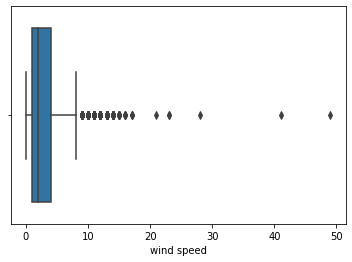

In [11]:
### checking for outliers in Wind Speed Column
sns.boxplot(Tel_Aviv['wind speed'])
print(Tel_Aviv['wind speed'].mode())

In [12]:
# let's drop those two outliers in wind speed column so they do not mess with out data
x = Tel_Aviv.loc[Tel_Aviv['wind speed'] > 10]

In [13]:
Tel_Aviv.drop(x.index, inplace = True)

In [14]:
# Handling missing values
Tel_Aviv['pressure'].fillna(1013.8, inplace = True)
Tel_Aviv['humidity'].fillna(66.9, inplace = True)
Tel_Aviv['temperature'].fillna(294.512307, inplace = True)
Tel_Aviv['wind speed'].fillna(2.0, inplace = True) # we use median here because of the outliers
Tel_Aviv['wind direction'].fillna(190.4, inplace = True)

In [15]:
Tel_Aviv.isnull().sum()

datetime          0
pressure          0
humidity          0
temperature       0
weather           0
wind direction    0
wind speed        0
date              0
year              0
month             0
day               0
hour              0
minute            0
second            0
dtype: int64

In [16]:
Tel_Aviv.head()

,datetime,pressure,humidity,temperature,weather,wind direction,wind speed,date,year,month,day,hour,minute,second
0,2012-10-01 12:00:00,1013.8,66.9,294.512307,sky is not clear,190.4,2.0,2012-10-01,2012,10,1,12,0,0
1,2012-10-01 13:00:00,1012.0,63.0,305.470000,sky is clear,0.0,0.0,2012-10-01,2012,10,1,13,0,0
2,2012-10-01 14:00:00,1012.0,62.0,304.310000,sky is clear,0.0,0.0,2012-10-01,2012,10,1,14,0,0
3,2012-10-01 15:00:00,1012.0,62.0,304.281841,sky is clear,0.0,0.0,2012-10-01,2012,10,1,15,0,0
4,2012-10-01 16:00:00,1012.0,62.0,304.238015,sky is clear,0.0,0.0,2012-10-01,2012,10,1,16,0,0


### creating features for average per day

In [17]:
Tel_Aviv['average pressure'] = Tel_Aviv.groupby('date')['pressure'].transform('mean')
Tel_Aviv['average humidity'] = Tel_Aviv.groupby('date')['humidity'].transform('mean')
Tel_Aviv['average temperature'] = Tel_Aviv.groupby('date')['temperature'].transform('mean')
Tel_Aviv['average wind direction'] = Tel_Aviv.groupby('date')['wind direction'].transform('mean')
Tel_Aviv['average wind speed'] = Tel_Aviv.groupby('date')['wind speed'].transform('mean')

### creating polynomial features from existing features

In [18]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2, interaction_only = True, include_bias= False)

In [19]:
poly_features = ['pressure', 'humidity', 'temperature', 'wind direction',
                 'wind speed', 'average pressure', 'average humidity',
                 'average temperature', 'average wind direction', 'average wind speed']

In [20]:
pol = poly.fit_transform(Tel_Aviv[poly_features])

In [21]:
df_pol = pd.DataFrame(pol, columns=[f"pol_{i}" for i in range(pol.shape[1])])

In [22]:
Tel_Aviv = pd.concat([Tel_Aviv, df_pol], axis = 1)

In [23]:
Tel_Aviv.columns

Index(['datetime', 'pressure', 'humidity', 'temperature', 'weather',
       'wind direction', 'wind speed', 'date', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'average pressure', 'average humidity',
       'average temperature', 'average wind direction', 'average wind speed',
       'pol_0', 'pol_1', 'pol_2', 'pol_3', 'pol_4', 'pol_5', 'pol_6', 'pol_7',
       'pol_8', 'pol_9', 'pol_10', 'pol_11', 'pol_12', 'pol_13', 'pol_14',
       'pol_15', 'pol_16', 'pol_17', 'pol_18', 'pol_19', 'pol_20', 'pol_21',
       'pol_22', 'pol_23', 'pol_24', 'pol_25', 'pol_26', 'pol_27', 'pol_28',
       'pol_29', 'pol_30', 'pol_31', 'pol_32', 'pol_33', 'pol_34', 'pol_35',
       'pol_36', 'pol_37', 'pol_38', 'pol_39', 'pol_40', 'pol_41', 'pol_42',
       'pol_43', 'pol_44', 'pol_45', 'pol_46', 'pol_47', 'pol_48', 'pol_49',
       'pol_50', 'pol_51', 'pol_52', 'pol_53', 'pol_54'],
      dtype='object')

In [24]:
Tel_Aviv.shape

(45253, 74)

In [25]:
Tel_Aviv.dropna(axis = 0, how = 'any', inplace = True)
Tel_Aviv.isnull().sum()

datetime       0
pressure       0
humidity       0
temperature    0
weather        0
              ..
pol_50         0
pol_51         0
pol_52         0
pol_53         0
pol_54         0
Length: 74, dtype: int64

In [26]:
Tel_Aviv.head()

,datetime,pressure,humidity,temperature,weather,wind direction,wind speed,date,year,month,day,hour,minute,second,average pressure,average humidity,average temperature,average wind direction,average wind speed,pol_0,pol_1,pol_2,pol_3,pol_4,pol_5,pol_6,pol_7,pol_8,pol_9,pol_10,pol_11,pol_12,pol_13,pol_14,pol_15,pol_16,pol_17,pol_18,pol_19,pol_20,pol_21,pol_22,pol_23,pol_24,pol_25,pol_26,pol_27,pol_28,pol_29,pol_30,pol_31,pol_32,pol_33,pol_34,pol_35,pol_36,pol_37,pol_38,pol_39,pol_40,pol_41,pol_42,pol_43,pol_44,pol_45,pol_46,pol_47,pol_48,pol_49,pol_50,pol_51,pol_52,pol_53,pol_54
0,2012-10-01 12:00:00,1013.8,66.9,294.512307,sky is not clear,190.4,2.0,2012-10-01,2012.0,10.0,1.0,12.0,0.0,0.0,1012.15,63.241667,303.437593,15.866667,0.583333,1013.8,66.9,294.512307,190.4,2.0,1012.15,63.241667,303.437593,15.866667,0.583333,67823.22,298576.576837,193027.52,2027.6,1026117.67,64114.401667,307625.031866,16085.626667,591.383333,19702.873338,12737.76,133.8,67712.835,4230.867500,20299.974977,1061.480000,39.025000,56075.143253,589.024614,298090.631530,18625.449149,89366.105569,4672.928604,171.798846,380.8,192713.36,12041.213333,57774.517723,3021.013333,111.066667,2024.3,126.483333,606.875186,31.733333,1.166667,64010.052917,307124.359838,16059.446667,590.420833,19189.899116,1003.434444,36.890972,4814.543144,177.005263,9.255556
1,2012-10-01 13:00:00,1012.0,63.0,305.470000,sky is clear,0.0,0.0,2012-10-01,2012.0,10.0,1.0,13.0,0.0,0.0,1012.15,63.241667,303.437593,15.866667,0.583333,1012.0,63.0,305.470000,0.0,0.0,1012.15,63.241667,303.437593,15.866667,0.583333,63756.00,309135.640000,0.00,0.0,1024295.80,64000.566667,307078.844199,16057.066667,590.333333,19244.610000,0.00,0.0,63765.450,3984.225000,19116.568364,999.600000,36.750000,0.000000,0.000000,309181.460500,19318.431917,92691.081559,4846.790667,178.190833,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,64010.052917,307124.359838,16059.446667,590.420833,19189.899116,1003.434444,36.890972,4814.543144,177.005263,9.255556
2,2012-10-01 14:00:00,1012.0,62.0,304.310000,sky is clear,0.0,0.0,2012-10-01,2012.0,10.0,1.0,14.0,0.0,0.0,1012.15,63.241667,303.437593,15.866667,0.583333,1012.0,62.0,304.310000,0.0,0.0,1012.15,63.241667,303.437593,15.866667,0.583333,62744.00,307961.720000,0.00,0.0,1024295.80,64000.566667,307078.844199,16057.066667,590.333333,18867.220000,0.00,0.0,62753.300,3920.983333,18813.130771,983.733333,36.166667,0.000000,0.000000,308007.366500,19245.071583,92339.093951,4828.385333,177.514167,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,64010.052917,307124.359838,16059.446667,590.420833,19189.899116,1003.434444,36.890972,4814.543144,177.005263,9.255556
3,2012-10-01 15:00:00,1012.0,62.0,304.281841,sky is clear,0.0,0.0,2012-10-01,2012.0,10.0,1.0,15.0,0.0,0.0,1012.15,63.241667,303.437593,15.866667,0.583333,1012.0,62.0,304.281841,0.0,0.0,1012.15,63.241667,303.437593,15.866667,0.583333,62744.00,307933.223427,0.00,0.0,1024295.80,64000.566667,307078.844199,16057.066667,590.333333,18865.474163,0.00,0.0,62753.300,3920.983333,18813.130771,983.733333,36.166667,0.000000,0.000000,307978.865703,19243.290782,92330.549552,4827.938549,177.497741,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,64010.052917,307124.359838,16059.446667,590.420833,19189.899116,1003.434444,36.890972,4814.543144,177.005263,9.255556
4,2012-10-01 16:00:00,1012.0,62.0,304.238015,sky is clear,0.0,0.0,2012-10-01,2012.0,10.0,1.0,16.0,0.0,0.0,1012.15,63.241667,303.437593,15.866667,0.583333,1012.0,62.0,304.238015,0.0,0.0,1012.15,63.241667,303.437593,15.866667,0.583333,62744.00,307888.870784,0.00,0.0,1024295.80,64000.566667,307078.844199,16057.066667,590.333333,18862.756906,0.00,0.0,62753.300,3920.983333,18813.130771,983.733333,36.166667,0.000000,0.000000,307934.506486,19240.519107,92317.250877,4827.243165,177.472175,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,64010.052917,307124.359838,16059

### checking for class imbalance

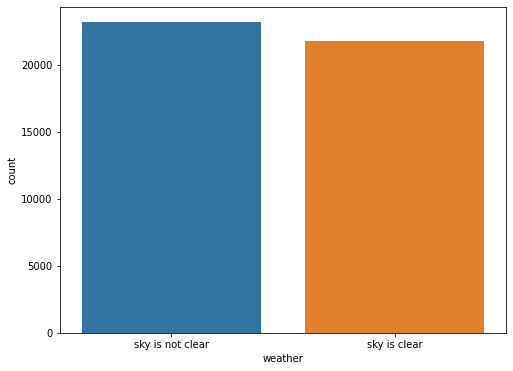

In [27]:
plt.figure(figsize = (8,6))
sns.countplot(Tel_Aviv['weather'])
plt.show()

In [29]:
# encoding categorical variables
le = LabelEncoder()
Tel_Aviv['weather'] = le.fit_transform(Tel_Aviv['weather'])

In [30]:
X = Tel_Aviv.drop(['weather', 'date', 'datetime'], axis = 1)
Y = Tel_Aviv['weather']

In [31]:
s_scaler = StandardScaler()
X = s_scaler.fit_transform(X)

In [32]:
total_f1 = []

fold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
i = 1
for train_index, test_index in fold.split(X, Y):
    X_TRAIN, X_TEST = X[train_index], X[test_index]
    Y_TRAIN, Y_TEST = Y.iloc[train_index], Y.iloc[test_index]
    
    lgbmc = lgb.LGBMClassifier()

    lgbmc.fit(X_TRAIN, Y_TRAIN)
    
    Y_PRED = lgbmc.predict(X_TEST)
    
    print(f"-------------------------- Fitting LGBM Classifier ----------------------- ")
    
    print(f"fold {i} f1_score : {f1_score(Y_TEST, Y_PRED)}")
    
    i + 1
    
    total_f1.append(f1_score(Y_TEST, Y_PRED))

print(f"-------------------- Mean F1-SCORE ------------------------")
print(np.mean(total_f1))

-------------------------- Fitting LGBM Classifier ----------------------- 
fold 1 f1_score : 0.8420828905419767
-------------------------- Fitting LGBM Classifier ----------------------- 
fold 1 f1_score : 0.8344739093242087
-------------------------- Fitting LGBM Classifier ----------------------- 
fold 1 f1_score : 0.8606034849128772
-------------------------- Fitting LGBM Classifier ----------------------- 
fold 1 f1_score : 0.841813923781137
-------------------------- Fitting LGBM Classifier ----------------------- 
fold 1 f1_score : 0.8421725239616614
-------------------------- Fitting LGBM Classifier ----------------------- 
fold 1 f1_score : 0.849181025313763
-------------------------- Fitting LGBM Classifier ----------------------- 
fold 1 f1_score : 0.8417910447761194
-------------------------- Fitting LGBM Classifier ----------------------- 
fold 1 f1_score : 0.8320136956986945
-------------------------- Fitting LGBM Classifier ----------------------- 
fold 1 f1_score : 0.84

In [33]:
print(classification_report(Y_TEST, Y_PRED))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      2172
           1       0.83      0.84      0.83      2315

    accuracy                           0.83      4487
   macro avg       0.83      0.83      0.83      4487
weighted avg       0.83      0.83      0.83      4487



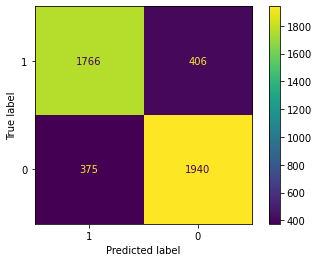

In [34]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(Y_TEST, Y_PRED), display_labels= [1,0])
cm_display.plot()
plt.show()

### Checking other algorithms

In [35]:
rfc = RandomForestClassifier(n_estimators = 500, max_depth = 6)

In [36]:
total_f1 = []

fold = StratifiedKFold(n_splits = 5)
i = 1
for train_index, test_index in fold.split(X, Y):
    X_TRAIN, X_TEST = X[train_index], X[test_index]
    Y_TRAIN, Y_TEST = Y.iloc[train_index], Y.iloc[test_index]
    
    rfc.fit(X_TRAIN, Y_TRAIN)
    
    Y_PRED = rfc.predict(X_TEST)
    
    print(f"-------------------------- Fitting Random Forest Classifier ----------------------- ")
    
    print(f"fold {i} f1_score : {f1_score(Y_TEST, Y_PRED)}")
    
    i + 1
    
    total_f1.append(f1_score(Y_TEST, Y_PRED))

print(f"-------------------- Mean F1-SCORE ------------------------")
print(np.mean(total_f1))

-------------------------- Fitting Random Forest Classifier ----------------------- 
fold 1 f1_score : 0.692256021495058
-------------------------- Fitting Random Forest Classifier ----------------------- 
fold 1 f1_score : 0.7081358609794629
-------------------------- Fitting Random Forest Classifier ----------------------- 
fold 1 f1_score : 0.7157104950132674
-------------------------- Fitting Random Forest Classifier ----------------------- 
fold 1 f1_score : 0.6535502585445833
-------------------------- Fitting Random Forest Classifier ----------------------- 
fold 1 f1_score : 0.6387052655573284
-------------------- Mean F1-SCORE ------------------------
0.68167158031794


In [37]:
total_f1 = []

fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
i = 1
for train_index, test_index in fold.split(X, Y):
    X_TRAIN, X_TEST = X[train_index], X[test_index]
    Y_TRAIN, Y_TEST = Y.iloc[train_index], Y.iloc[test_index]
    
    xgbc = xgb.XGBClassifier()

    xgbc.fit(X_TRAIN, Y_TRAIN)
    
    Y_PRED = xgbc.predict(X_TEST)
    
    print(f"-------------------------- Fitting XGBoost Classifier ----------------------- ")
    
    print(f"fold {i} f1_score : {f1_score(Y_TEST, Y_PRED)}")
    
    i + 1
    
    total_f1.append(f1_score(Y_TEST, Y_PRED))

print(f"-------------------- Mean F1-SCORE ------------------------")
print(np.mean(total_f1))

-------------------------- Fitting XGBoost Classifier ----------------------- 
fold 1 f1_score : 0.7700134980791196
-------------------------- Fitting XGBoost Classifier ----------------------- 
fold 1 f1_score : 0.786888657648283
-------------------------- Fitting XGBoost Classifier ----------------------- 
fold 1 f1_score : 0.7861392339004278
-------------------------- Fitting XGBoost Classifier ----------------------- 
fold 1 f1_score : 0.7747916666666667
-------------------------- Fitting XGBoost Classifier ----------------------- 
fold 1 f1_score : 0.7724094751121778
-------------------- Mean F1-SCORE ------------------------
0.7780485062813349


In [38]:
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [39]:
total_f1 = []

fold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
i = 1
for train_index, test_index in fold.split(X, Y):
    X_TRAIN, X_TEST = X[train_index], X[test_index]
    Y_TRAIN, Y_TEST = Y.iloc[train_index], Y.iloc[test_index]
    
    lr.fit(X_TRAIN, Y_TRAIN)
    
    Y_PRED = lr.predict(X_TEST)
    
    print(f"-------------------------- Fitting Logistic Regression Classifier ----------------------- ")
    
    print(f"fold {i} f1_score : {f1_score(Y_TEST, Y_PRED)}")
    
    i + 1
    
    total_f1.append(f1_score(Y_TEST, Y_PRED))

print(f"-------------------- Mean F1-SCORE ------------------------")
print(np.mean(total_f1))

-------------------------- Fitting Logistic Regression Classifier ----------------------- 
fold 1 f1_score : 0.7012118679481822
-------------------------- Fitting Logistic Regression Classifier ----------------------- 
fold 1 f1_score : 0.7046368833368623
-------------------------- Fitting Logistic Regression Classifier ----------------------- 
fold 1 f1_score : 0.7236758136566688
-------------------------- Fitting Logistic Regression Classifier ----------------------- 
fold 1 f1_score : 0.7079081632653063
-------------------------- Fitting Logistic Regression Classifier ----------------------- 
fold 1 f1_score : 0.7072340425531914
-------------------------- Fitting Logistic Regression Classifier ----------------------- 
fold 1 f1_score : 0.7137704222363676
-------------------------- Fitting Logistic Regression Classifier ----------------------- 
fold 1 f1_score : 0.7066553624417126
-------------------------- Fitting Logistic Regression Classifier ----------------------- 
fold 1 f1_sco

### other algorithms show lower performance so we are sticking with LGBM Classifier

In [40]:
import pickle

In [41]:
with open('model.pkl', 'wb') as files:
  pickle.dump(lgbmc, files)